# Naive Bayes i Classificació


En aquest tercer lliurament es programarà un classificador, que donada una *piulada*, la categoritzarà en una de les possibles classes. En aquesta ocasió, implementareu un classificador amb *piulades* relacionades amb el *cyber bullying*.

Recordeu que l'objectiu principal d'aquesta pràctica és desenvolupar un classificador amb una *accuracy* alta. 


**Què s’ha de fer?**

Volem classificar *piulades* segons a quin tipus de *cyber bullying* pertanyen. Així doncs, a partir de tots les *piulades* que tenim, crearem un vector de característiques que ens descrigui cadascuna. A continuació desenvoluparem un classificador probabilístic del tipus **Naive Bayes** que ens permeti identificar a quina classe de *cyber bullying* pertany una *piulada* donada, segons les característiques disenyades.


**Quina és la idea del sistema de classificació que s’ha de desenvolupar?**

El classificador és un concepte de l'aprenentatge automàtic supervisat. L'objectiu del classificador és donat un vector de característiques que descriuen els objectes que es volen classificar indicar a quina categoria o classe pertanyen d'entre un conjunt predeterminat. 

El procés de classificació consta de dues parts: 

+ el procés d'aprenentatge i 
+ el procés d'explotació o testeig. 

El procés d'aprenentatge rep exemples de parelles $(x,y)$ on $x$ són les característiques, usualment representades per nombres reals, i $y$ és la categoria a la que pertanyen. 
Aquest conjunt se'l coneix com a conjunt d'entrenament i ens servirà per trobar una funció $\hat{y}=f(x)$ que donada una $x$ aconsegueixi que $\hat{y}$ sigui semblant $y$. 

Per altra banda el procés de testeig aplica la funció $f(x)$ apresa a l'entrenament a a dades no presents en el conjunt d'aprenentatge per avaluar el classificador.

**Classificació i llenguatge natural**

La descripció dels exemples en característiques és el punt més crític de tot sistema d'aprenentatge automàtic. 
Una de les representacions més simples per tal de descriure un text és la representació ["bag-of-words"](https://en.wikipedia.org/wiki/Bag-of-words_model).

Aquesta representació converteix un text en un vector de $N$ paraules. 
Primer haurem de seleccionar el conjunt d'$N$ paraules que volem fer servir. Després, per cada paraula comptar quants cops apareix en el text. 

Una versió alternativa i més simple d'aquest procés pot ser simplement indicar al vector si una determinada paraula apareix o no en el text.

## Abans de començar


**\+ Durant la pràctica, solament es podran fer servir les següents llibreries**:

`Pandas, Numpy, Re` i `NLTK`

Python té un paquet integrat anomenat ["re"](https://www.w3schools.com/python/python_regex.asp), que es pot utilitzar per treballar amb expressions regulars. És molt aconsellable fer servir aquest paquet per processar les paraules.

**\+ No es poden modificar les definicions de les funcions donades, ni canviar els noms de les variables i paràmetres ja donats**

Això no implica però que els hàgiu de fer servir. És a dir, que la funció tingui un paràmetre anomenat `df` no implica que l'hàgiu de fer servir, si no ho trobeu convenient.

**\+ En les funcions, s'especifica que serà i de quin tipus cada un dels paràmetres, cal respectar-ho**

Per exemple (ho posarà en el pydoc de la funció), `df` sempre serà indicatiu del `Pandas.DataFrame` de les dades. Durant els testos, els paràmetres (i específicament `df`) no contindran les mateixes dades que en aquest notebook, si bé si seran del mateix tipus! Per tant, no us refieu de què tinguin, per exemple, el mateix nombre de files.

## Les dades

El 15 d'Abril de 2020, UNICEF va llançar una alarma com a resposta de l'augment de risc de *cyber bullying* durant la pandèmia COVID-19. 

Les estadístiques són prou alarmants: un 36.5% dels estudiants de l'escola fins a l'institut s'han sentit víctimes del *cyber bullying* i un 87% n'han estat testimonis, amb efectes que van des d'una disminució de resultats acadèmics fins a pensaments suïcides.

Amb l'objectiu d'ajudar a l'analisis de la situació, s'ha construit un dataset que conté més de 47000 *piulades* etiquetades d'acord amb la classe de *cyber bullying* que s'està donant:

1. `age`;
2. `ethnicity`;
3. `gender`;
4. `religion`;
5. `other type of cyberbullying`;
6. `not cyberbullying`

Les dades han estat balancejades per tal de contenir aproximadament 8000 mostres de cada classe.

# Preparar les dades

## Lectura de les dades

In [78]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\artur\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\artur\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
df = pd.read_csv('data/cyberbullying_tweets.csv')
df

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying
...,...,...
47687,"Black ppl aren't expected to do anything, depe...",ethnicity
47688,Turner did not withhold his disappointment. Tu...,ethnicity
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity


In [3]:
df['cyberbullying_type'].value_counts()

religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: cyberbullying_type, dtype: int64

## Preparació del dataset

Dividim les *piulades* en un conjunt d'entrenament, *train*, i en un conjunt de validació, *test*, per tal de poder entrenar i validar el nostre model de classificació.

In [4]:
from sklearn.model_selection import train_test_split

df_tweets_train, df_tweets_test = train_test_split(df, test_size=0.2)

Com les dades estaven balancejades originalment, podem observar que la distribució de cadascuna de les classes es manté:

In [5]:
df_tweets_train['cyberbullying_type'].value_counts()

ethnicity              6402
religion               6394
age                    6381
gender                 6349
not_cyberbullying      6327
other_cyberbullying    6300
Name: cyberbullying_type, dtype: int64

In [6]:
df_tweets_test['cyberbullying_type'].value_counts()

gender                 1624
not_cyberbullying      1618
age                    1611
religion               1604
ethnicity              1559
other_cyberbullying    1523
Name: cyberbullying_type, dtype: int64

# Implementació

Dividirem el notebook en 3 seccions que es complementen una a l'altra:

1. Anàlisi exploratòria de les dades: Informació bàsica sobre les *piulades*.
2. Processament de les dades: Creació d'un vector de característiques a partir de les *piulades*.
3. Desenvolupament d'un classificador *Naive Bayes*. 

### 1. Anàlisis de dades

El primer que haurem de fer és analitzar les dades per veure una mica com són. El que us proposem és fer una sèrie de visualitzacions per observar les dades, com ara:

* el nombre de *piulades* que s'estan dirigint a una persona en concret
* el nombre de  *hashtags* que hi ha a cada categoria de *piulades*
* el nombre de  *piulades* que hi ha de cada categoria de *piulades*
* el nombre de  *piulades* de la categoria `not_cyberbullying` que es dirigeixen a un usuari vs totes les altres categories
* altres coses que penseu que poden ser rellevants.

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

# 1. Nombre de *piulades* que se están dirigiendo a una persona en concreto
piulades_a_persona = df[df['cyberbullying_type'] != 'not_cyberbullying']['tweet_text']
num_piulades_a_persona = len(piulades_a_persona)

# 2. Nombre de *hashtags* que hay en cada categoría de *piulades*
hashtags_por_categoria = df.groupby('cyberbullying_type')['tweet_text'].apply(lambda x: ' '.join(x).count('#'))
hashtags_por_categoria = hashtags_por_categoria.rename_axis('Categoría').reset_index(name='Número de Hashtags')

# 3. Nombre de *piulades* que hay de cada categoría de *piulades*
num_piulades_por_categoria = df['cyberbullying_type'].value_counts().rename_axis('Categoría').reset_index(name='Número de Piulades')

# 4. Nombre de *piulades* de la categoría `not_cyberbullying` que se dirigen a un usuario vs todas las otras categorías
piulades_not_cyberbullying = df[df['cyberbullying_type'] == 'not_cyberbullying']['tweet_text']
num_piulades_not_cyberbullying_a_usuario = piulades_not_cyberbullying.str.contains('@').sum()
num_piulades_not_cyberbullying_otras_categorias = df[df['cyberbullying_type'] != 'not_cyberbullying']['tweet_text'].str.contains('@').sum()

# Resultados
print(f"1. Nombre de piulades que se están dirigiendo a una persona en concreto: {num_piulades_a_persona}\n")

print("2. Nombre de hashtags que hay en cada categoría de piulades:")
print(hashtags_por_categoria.to_string(index=False), end='\n\n')

print("3. Nombre de piulades que hay de cada categoría de piulades:")
print(num_piulades_por_categoria.to_string(index=False), end='\n\n')

print(f"4. Nombre de piulades de la categoría `not_cyberbullying` que se dirigen a un usuario vs todas las otras categorías:")
print(f"   - Not Cyberbullying a usuario: {num_piulades_not_cyberbullying_a_usuario}")
print(f"   - Otras categorías a usuario: {num_piulades_not_cyberbullying_otras_categorias}")

1. Nombre de piulades que se están dirigiendo a una persona en concreto: 39747

2. Nombre de hashtags que hay en cada categoría de piulades:
          Categoría  Número de Hashtags
                age                 743
          ethnicity                1118
             gender                2722
  not_cyberbullying                3285
other_cyberbullying                1648
           religion                1805

3. Nombre de piulades que hay de cada categoría de piulades:
          Categoría  Número de Piulades
           religion                7998
                age                7992
             gender                7973
          ethnicity                7961
  not_cyberbullying                7945
other_cyberbullying                7823

4. Nombre de piulades de la categoría `not_cyberbullying` que se dirigen a un usuario vs todas las otras categorías:
   - Not Cyberbullying a usuario: 4149
   - Otras categorías a usuario: 13990


In [8]:
df_tweets_train.head()

,tweet_text,cyberbullying_type
14825,RT @Alex_Gon1 Call me sexist or whatever...but...,gender
42245,I beg everyone that if you EVER see a black pe...,ethnicity
22536,@thepoliticalcat @MaxBlumenthal @Campagnebds B...,religion
13261,RT @asredasmyhair: How can feminists claim we...,gender
6193,RT @sudixitca: US should help Egypt and provid...,not_cyberbullying


#### **EXERCICI 1:** 

* Quantes *piulades* estan dirigides a un usuari concret? Diem que una piulada va dirigida a una persona en concret si contenen el patró ``@usuari``. 

[Restriccions](https://help.twitter.com/en/managing-your-account/change-twitter-handle) que imposa X sobre el patró:
+ Nomes són valids aquells patrons amb caràcters alfanumèrics ``[A-z 0-9]`` i el caràcter ``_``
+ Els patrons han de començar per ``@`` i han de tenir més de 4 i menys de 16 caràcters.

En aquest exercici és extremadament útil l'ús del mòdul ``re``.

In [9]:
def piulades_to_user(df):
    """
    Cuenta cuántas piulades están dirigidas a un usuario concreto en un DataFrame.

    Parameters:
    - df: DataFrame que contiene la columna 'tweet_text'.

    Returns:
    - Número de piulades dirigidas a un usuario concreto.
    """

    # Restricciones del patrón de usuario
    patron_usuario = re.compile(r'@([A-Za-z0-9_]{4,15})\b')

    # Contar las piulades dirigidas a un usuario concreto
    piulades_dirigidas_a_usuario = df['tweet_text'].apply(lambda x: bool(re.search(patron_usuario, x))).sum()

    return piulades_dirigidas_a_usuario

In [10]:
print(piulades_to_user(df))

print(piulades_to_user(df_tweets_train) + piulades_to_user(df_tweets_test))

17976
17976


+ Quants *hashtags* ``#`` hi ha a cada categoria de *piulades*?

Compteu els ``#`` que vagin seguits d'alguna lletra o nombre ja que, com veiem a la [normativa](https://help.twitter.com/en/using-twitter/how-to-use-hashtags) de X, els ``#`` no poden contenir cap mena de signe de puntuació.

In [11]:
def count_hashtag(text):
    normativa = re.compile(r'#([A-Za-z0-9]+)\b')
    hashtags = re.findall(normativa, text)
    return len(hashtags)


def hashtag_category(dataFrame):
    dataFrame['num_hashtags'] = dataFrame['tweet_text'].apply(count_hashtag)
    hashtags_por_categoria = df.groupby('cyberbullying_type')['num_hashtags'].sum().reset_index()
    hashtags_por_categoria = hashtags_por_categoria.rename(columns={'cyberbullying_type': 'Categoría', 'num_hashtags': 'Número de Hashtags'})
    return hashtags_por_categoria

# Obtener el DataFrame con el número de hashtags por categoría
resultado_hashtags = hashtag_category(df)

resultado_hashtags

,Categoría,Número de Hashtags
0,age,725
1,ethnicity,1101
2,gender,2688
3,not_cyberbullying,3252
4,other_cyberbullying,1608
5,religion,1706


+ Fes un histograma que representi aquesta distribució?

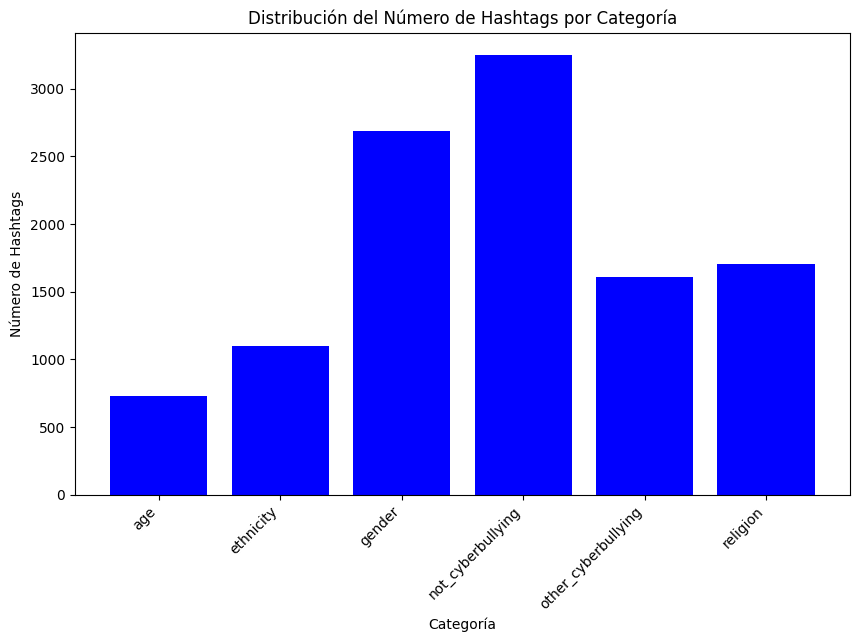

In [12]:
# Configurar el tamaño del gráfico
plt.figure(figsize=(10, 6))

# Crear el histograma
plt.bar(resultado_hashtags['Categoría'], resultado_hashtags['Número de Hashtags'], color='blue')

# Configurar el título y etiquetas
plt.title('Distribución del Número de Hashtags por Categoría')
plt.xlabel('Categoría')

# Rotar las etiquetas del eje x para evitar solapamientos
plt.xticks(rotation=45, ha="right")

plt.ylabel('Número de Hashtags')

# Mostrar el histograma
plt.show()

+ Comproveu a continuació quantes vegades hi ha un ús invàlid dels ``#``, per exemple ``##`` o ``#@``, on, si no tinguessim en compte la restriccio imposada, hauriem contat 2 ``#`` a ``##`` o 1 ``#`` a ``#@``, quan en realitat son 1 i 0 respectivament.

In [13]:
def count_invalid_uses(text):
    uses_invalid_restriction = re.compile(r'#\W*#|#@')
    uses_invalid = re.findall(uses_invalid_restriction, text)
    return len(uses_invalid)

def count_invalid(dataFrame):
    dataFrame['num_usos_invalidos'] = dataFrame['tweet_text'].apply(count_invalid_uses)

    # Mostrar el número total de usos inválidos de '#' en el conjunto de datos
    return dataFrame['num_usos_invalidos'].sum()

In [14]:
total_uses_invalid = count_invalid(df)
total_uses_invalid

9

+ Quantes *piulades* vàlides hi ha de cada categoria?

In [15]:
def valid_hashtag(dataFrame):
    dataFrame['num_hashtags'] = dataFrame['tweet_text'].apply(count_hashtag)
    dataFrame['num_usos_invalidos'] = dataFrame['tweet_text'].apply(count_invalid_uses)

    # Calcular el número de piulades válidas por categoría
    dataFrame['num_piulades_validas'] = dataFrame.groupby('cyberbullying_type')['tweet_text'].transform('count') - dataFrame['num_usos_invalidos']

    # Obtener el DataFrame con el número de hashtags por categoría
    hashtags_por_categoria = dataFrame.groupby('cyberbullying_type')[['num_hashtags', 'num_piulades_validas']].sum().reset_index()
    hashtags_por_categoria = hashtags_por_categoria.rename(columns={'cyberbullying_type': 'Categoría', 'num_hashtags': 'Número de Hashtags', 'num_piulades_validas': 'Número de Piulades Válidas'})

    return hashtags_por_categoria


In [16]:
valid_hashtag = valid_hashtag(df)
valid_hashtag

,Categoría,Número de Hashtags,Número de Piulades Válidas
0,age,725,63872062
1,ethnicity,1101,63377517
2,gender,2688,63568728
3,not_cyberbullying,3252,63123023
4,other_cyberbullying,1608,61199329
5,religion,1706,63968004


+ Quantes *piulades* de la categoria `not_cyberbullying` és dirigeixen a un usuari?
+ Quantes *piulades* de totes les altres categories és dirigeixen a un usuari?

In [17]:
# Obtener el número de piulades de la categoría `not_cyberbullying` dirigidas a un usuario
piulades_not_cyberbullying_to_user = piulades_to_user(df[df['cyberbullying_type'] == 'not_cyberbullying'])

# Obtener el número de piulades de todas las demás categorías dirigidas a un usuario
piulades_other_categories_to_user = piulades_to_user(df[df['cyberbullying_type'] != 'not_cyberbullying'])

# Mostrar los resultados
print(f"Número de piulades de la categoría 'not_cyberbullying' dirigidas a un usuario: {piulades_not_cyberbullying_to_user}")
print(f"Número de piulades de otras categorías dirigidas a un usuario: {piulades_other_categories_to_user}")

Número de piulades de la categoría 'not_cyberbullying' dirigidas a un usuario: 4124
Número de piulades de otras categorías dirigidas a un usuario: 13852


+ Calculeu altres coses que penseu que poden ser rellevants (usuaris més mencionats, *hashtags* més comuns per cada categoria, etc.).

In [18]:
def more_users(text):
    """
    Extrae los usuarios mencionados en un texto.

    Parameters:
    - text: Cadena de texto.

    Returns:
    - Lista de usuarios mencionados.
    """
    user = re.compile(r'@([A-Za-z0-9_]{4,15})\b')
    user_mention = re.findall(user, text)
    return user_mention

def hashtag_count(text):
    """
    Extrae los hashtags en un texto.

    Parameters:
    - text: Cadena de texto.

    Returns:
    - Lista de hashtags.
    """
    hashtag_valid = re.compile(r'#([A-Za-z0-9]+)\b')
    hashtags = re.findall(hashtag_valid, text)
    return hashtags



In [19]:
# Obtener usuarios más mencionados por cada categoría (limitado a los 5 más comunes)
df['mention'] = df['tweet_text'].apply(more_users)
usuarios_mencionados_por_categoria = df.groupby('cyberbullying_type')['mention'].apply(lambda x: pd.Series([item for sublist in x for item in sublist]).value_counts().head(5).reset_index())
usuarios_mencionados_por_categoria = usuarios_mencionados_por_categoria.rename(columns={'index': 'Usuario'})

# Mostrar los resultados
print("Usuarios más mencionados por cada categoría:")
usuarios_mencionados_por_categoria

Usuarios más mencionados por cada categoría:


Usuario    0
cyberbullying_type                         
age                 0  realDonaldTrump   15
                    1           Change   14
                    2            POTUS    7
                    3           CDCgov    6
                    4   HouseDemocrats    5
ethnicity           0        tayyoung_  958
                    1     Colton_Zappe   33
                    2   MikeSimsWalker   22
                    3      goshawty123   18
                    4  AntiDARKSKINNED   16
gender              0            MT8_9   89
                    1   YesYoureSexist   57
                    2       RepTedYoho   37
                    3   mykitchenrules   30
                    4   Feminazi_Front   20
not_cyberbullying   0      freebsdgirl   75
                    1   mykitchenrules   67
                    2    greenlinerzjm   45
                    3    MaxBlumenthal   41
                    4       halalflaws   41
other_cyberbullying 0      freebsdgirl  151
                    1  TheQuinnspiracy   76
                    2    ChrisWarcraft   69
                    3      Spacekatgal   63
                    4   a_man_in_black   55
religion            0    MaxBlumenthal  119
                    1    IsraeliRegime   82
                    2    sajid_fairooz   65
                    3       Vandaliser   57
                    4  realDonaldTrump   50

In [20]:
# Obtener hashtags más comunes por cada categoría (limitado a los 5 más comunes)
df['hashtags'] = df['tweet_text'].apply(hashtag_count)
hashtags_por_categoria = df.groupby('cyberbullying_type')['hashtags'].apply(lambda x: pd.Series([item for sublist in x for item in sublist]).value_counts().head(5).reset_index())
hashtags_por_categoria = hashtags_por_categoria.rename(columns={'index': 'Hashtag'})


print("\nHashtags más comunes por cada categoría:")
hashtags_por_categoria


Hashtags más comunes por cada categoría:


Hashtag    0
cyberbullying_type                        
age                 0          SFFpit   16
                    1              MG   15
                    2        bullying   13
                    3     TheBachelor   10
                    4           bully    8
ethnicity           0          racism   22
                    1            coon   19
                    2          nigger   15
                    3         niggers   14
                    4          Racism   11
gender              0             mkr  319
                    1             MKR  312
                    2       notsexist  103
                    3      MileyCyrus   68
                    4       NotSexist   56
not_cyberbullying   0             MKR  821
                    1             mkr  770
                    2         MKR2015   43
                    3         mkr2015   39
                    4            ISIS   36
other_cyberbullying 0             MKR  182
                    1             mkr  103
                    2  BlameOneNotAll  100
                    3            coon   54
                    4  stopwadhwa2015   30
religion            0           Islam  124
                    1            ISIS   54
                    2           Jihad   30
                    3      Terrorists   18
                    4        Pakistan   16

### 2. Comptar paraules

In [21]:
# No modificar aquesta cel·la, s'encarrega de fer el procés més eficient.
# Intenteu entendre quà fa aquesta cel·la

def memo(f):
    class memodict(dict):
        def __init__(self, f):
            self.f = f
        def __call__(self, *args):
            return self[args]
        def __missing__(self, key):
            ret = self[key] = self.f(*key)
            return ret
    return memodict(f)

El primer que haurem d'implementar és la funció ``standardize`` que estandaritzarà les paraules.

#### **EXERCICI 2:** 

+ Empleneu la funció següent que, donada una paraula, la estandaritzi les paraules passant tots els caràcters a minúscules.

**Observació:** Podeu considerar diverses possibilitats per aquesta funció:
* Només canviar les lletres majúscules per minúscules
* Eliminar tots els símbols que no siguin @, # i _ (i substituïr-los per un espai)
* Eliminar tots els símbols (i substituïr-los per un espai)
* etc.

El mòdul `re` de Python és especialment útil en aquest punt. 

Trieu aquella possibilitat que dóna millor resultats a l'exercici 7!

In [22]:
@memo    
def standardize(word):
    """
    :param word: paraula a estandaritzar
    :return : paraula estandaritzada
    """
    
    # Convertir totes les lletres a minúscules
    word = word.lower()
    
    # Eliminar tots els caràcters que no siguin lletres, "@" o "#"
    word = re.sub(r'[^a-z@#]', ' ', word)
    
    return word


In [23]:
standardize("Taller DELS noUS USOS")

'taller dels nous usos'

#### **EXERCICI 3:** 

+ Feu una funció ``count_words`` que construeixi un diccionari que contingui totes les paraules que s'han trobat al dataset, tot indicant el total de cops que ha aparegut cadascuna i el nombre de piulades on apareix. 

El resultat ha de ser un diccionari d'aquest tipus (no necessàriament amb aquest valors):

```python
{
    'memory' : {'n_ocur': 88, 'n_piu': 76},
    'best': {'n_ocur': 123, 'n_piu': 65},
    ...
}
```

In [24]:
def count_words(df):
    """
    :param df: DataFrame amb les piulades i la informació associada
    :return : Diccionari amb el format {word : {n_ocur: valor, n_tweets: valor}, ...}
    """

    # Inicialitzar el diccionari
    dicc = {}

    # Iterar sobre cada fila del DataFrame
    for index, row in df.iterrows():
        # Obtindre la llista de paraules de la piulada
        words = row['tweet_text'].split()

        # Iterar sobre cada paraula
        for word in words:
            # Estandaritzar la paraula
            standardized_word = standardize(word)

            # Actualitzar el diccionari
            if standardized_word in dicc:
                dicc[standardized_word]['n_ocur'] += 1
                if index not in dicc[standardized_word]['n_tweets']:
                    dicc[standardized_word]['n_tweets'].append(index)
            else:
                dicc[standardized_word] = {'n_ocur': 1, 'n_tweets': [index]}

    return dicc

In [25]:
dicc_text = count_words(df_tweets_train)
print (len(dicc_text))
print("'rape':",dicc_text['rape'])

74360
'rape': {'n_ocur': 2787, 'n_tweets': [8510, 13621, 15486, 22714, 10637, 10359, 14269, 13543, 8007, 11432, 11192, 9780, 8057, 8150, 21723, 11357, 13234, 14098, 11073, 14336, 9485, 9711, 14416, 41097, 12000, 13826, 13173, 14438, 11819, 13162, 9512, 13352, 15398, 15218, 14096, 15055, 8381, 11832, 9405, 9288, 11170, 14484, 12390, 13272, 11268, 10591, 10947, 8651, 15826, 8792, 11347, 11828, 14992, 12685, 9766, 11618, 8274, 10707, 12228, 11684, 12418, 9048, 14762, 12016, 9013, 13906, 13454, 11096, 9754, 17017, 10450, 14337, 11025, 12343, 14948, 9345, 11003, 14632, 8361, 8864, 11207, 9445, 8767, 8676, 14960, 8038, 15179, 44339, 14236, 9958, 10188, 2937, 9822, 12854, 12051, 12316, 9585, 9008, 13067, 10327, 11540, 14335, 12762, 11628, 8254, 10015, 13363, 13969, 11871, 12879, 8261, 13544, 11741, 9848, 10100, 15848, 10189, 15612, 9508, 10735, 9249, 8168, 13081, 11961, 14506, 14676, 7959, 14424, 15559, 14015, 12468, 8941, 13148, 13417, 11061, 10755, 11669, 14280, 3361, 14425, 10142, 15554, 1

### 3. Comptar paraules per cada categoria de piulada

In [26]:
df_tweets_train.head()

,tweet_text,cyberbullying_type
14825,RT @Alex_Gon1 Call me sexist or whatever...but...,gender
42245,I beg everyone that if you EVER see a black pe...,ethnicity
22536,@thepoliticalcat @MaxBlumenthal @Campagnebds B...,religion
13261,RT @asredasmyhair: How can feminists claim we...,gender
6193,RT @sudixitca: US should help Egypt and provid...,not_cyberbullying


#### **EXERCICI 4:** 

+ Fent servir la funció que se us dona a continuació (`eachTopic`), apliqueu-la per tal de comptar les paraules que s'han trobat i la seva ocurrència segregant ara per categoria.

El resultat ha de ser un diccionari d'aquest tipus (no necessàriament amb aquest valors):

```python
{
    'ethnicity': {
        'race' : {'n_ocur': 88, 'n_piu': 76},
        'what': {'n_ocur': 123, 'n_piu': 65}
        ...
    },
    ...
    'gender': {
        'jokes' : {'n_ocur': 18, 'n_piu': 17},
        'you': {'n_ocur': 154, 'n_piu': 66}
    }
    ...
}
```

In [27]:
def count_words_categories(df):
    """
    Funció que ha de constuir un diccionari que conté la freqüència de les 
    paraules i el número de piulades on ha aparegut. 
    Aquesta informació ha de ser dividida per diferents categories de cyberbullying.
    
    :param df: DataFrame amb les piulades i la informació associada
    :return : Diccionari amb el format {label : {word : {n_ocur: valor, n_news: valor} } }
    """
    words_topic = {}
    
    def eachTopic(group):
        # Comptar paraules en aquest tema i desar-ho al diccionari
        words_topic[group['cyberbullying_type'].iloc[0]] = count_words(group)
    
    # Grupar el DataFrame pel tipus de cyberbullying i aplicar la funció eachTopic
    df.groupby('cyberbullying_type').apply(eachTopic)
    
    return words_topic


In [28]:
words_categories = count_words_categories(df_tweets_train)
print ("Categories:", len(words_categories))
print ("La paraula 'muslims' a la categoria 'religion':", words_categories["religion"]['muslims'])

Categories: 6
La paraula 'muslims' a la categoria 'religion': {'n_ocur': 1449, 'n_tweets': [22686, 16186, 23074, 18742, 21946, 18119, 22571, 21188, 20993, 20487, 17227, 20880, 19639, 22785, 16533, 16217, 20654, 18309, 18262, 17171, 16676, 23845, 22838, 21137, 21995, 16076, 22420, 17237, 17017, 16946, 19935, 21599, 21409, 19810, 16819, 23286, 16889, 21575, 20273, 23703, 17257, 16166, 22441, 22279, 19169, 21644, 17780, 20285, 21886, 19284, 23632, 22751, 23462, 17601, 23558, 18593, 21136, 23475, 20438, 20023, 20676, 23574, 19752, 16434, 21314, 21233, 21652, 20317, 18088, 23913, 22444, 16999, 18246, 21851, 19156, 20474, 22394, 21562, 16348, 21679, 23138, 18586, 16145, 18128, 18860, 16753, 18044, 16857, 21143, 19709, 23598, 19943, 16623, 21480, 16681, 17344, 16249, 16861, 20558, 17802, 18536, 20274, 18303, 19058, 18827, 18090, 23039, 16545, 21913, 22880, 22333, 17076, 16180, 22220, 22955, 23764, 18003, 19534, 20795, 17646, 19835, 19910, 18377, 18022, 23012, 21555, 16048, 23786, 18702, 16749

### 4. Paraules més freqüents a les piulades


**El problema de com escollir el vector de carecterístiques**

L'elecció de les paraules que formen el vector de característiques és un pas crític. En funció de com de bona sigui aquesta descripció, millor funcionarà el sistema. Tot i que us deixem a vosaltres la política de creació del vector de característiques us donem una pista: una possible estratègia és agafar aquelles paraules que apareixen entre en un 10 i un 50 percent del total de piludades (sense tenir en compte la categoria). És a dir, paraules que no són ni massa freqüents ni massa poc. Podeu experimentar variant aquests valors.

Una altra estratègia interessant és eliminar "stop words".

#### **EXERCICI 5:** 

+ Feu una funció ``topNwords`` que crei un diccionari amb les N paraules més representatives (les que apareixen amb més freqüència) de cadascuna de les categories de *cyberbullying* (Tenint en compte que haureu tret aquelles paraules que apareixen en la majoria de piulades, així com també, les que únicament apareixen en un conjunt molt petit de piulades). Una pista de que aneu ben encaminats es que per cadascuna de les categories de *cyberbullying* obtingueu paraules rellevants per aquesta. Si no es així, vol dir que heu d'incrementar el nombre de paraules a saltar (*skip_top*).

El resultat serà un diccionari tipus (no necessàriament amb aquest valors):

```python
{
    'age': ['school', 'high', ...],
    ...
    'religion': ['muslims', 'christian',...]
    ...
}
```

+ Experimenteu omplint la llista `skip_top` amb aquelles paraules que penseu no tenen significat o relevancia per definir cada categoria. Podeu buscar informació sobre **stop words** a internet i definir varies llistes fins que penseu que obteniu una bona representació de paraules per categoria de `cyberbullying`.

In [160]:
def topNwords(df, words, N, skip):
    """
    :param df: DataFrame amb les piulades i la informació associada
    :param words: diccionari amb les paraules i la seva frequencia
    :param N: número de paraules més representatives que volem considerar
    :return : Diccionari amb el format {categoria1: llista_top_words_cat_1,  
                                        categoria2: llista_top_words_cat_2, ...} 
    """
    top_words = {}

    # Recórrer les categories
    for category, word_freq in words.items():
        # Ordenar el diccionari de paraules per freqüència en ordre descendent
        sorted_words = sorted(word_freq.items(), key=lambda x: x[1]['n_ocur'], reverse=True)

        # Filtrar les paraules que han d'ésser ignorades
        filtered_words = [word for word, freq in sorted_words if word not in skip]

        # Agafar les N paraules més representatives
        top_words[category] = filtered_words[:N]

    return top_words

In [175]:
# Codi adicional per fer testeig

# Prova amb el DataFrame de training i les paraules obtingudes de l'exercici 4 (words_categories_train)
N = 10  # Podeu ajustar aquest valor segons les vostres preferències

#Llista treta del seguent link, hem convertit el txt a csv: https://countwordsfree.com/stopwords

skip_top_df = pd.read_csv('data/stop_words_english.csv')
#Per a que sigui un array:
skip_top = skip_top_df.iloc[:, 0].to_numpy()

words_categories = count_words_categories(df_tweets_train)

# Crida a la funció topNwords
top_words_result = topNwords(df_tweets_train, words_categories, N, skip_top)

# Imprimir el resultat
for category, top_words_list in top_words_result.items():
    print(f"Top {N} paraules més representatives per a la categoria '{category}': {top_words_list}")

Top 10 paraules més representatives per a la categoria 'age': ['school', 'high', 'bullied', 'bully', 'girls', 'girl', 'school ', ' ', 'bullies', 'people']
Top 10 paraules més representatives per a la categoria 'ethnicity': ['dumb', 'fuck', 'nigger', 'ass', 'black', ' ', 'white', 'rt', 'nigger ', 'obama ']
Top 10 paraules més representatives per a la categoria 'gender': ['rape', 'gay', 'jokes', 'rt', 'joke', ' ', 'jokes ', 'i m', 'people', 'don t']
Top 10 paraules més representatives per a la categoria 'not_cyberbullying': ['#mkr', ' ', 'rt', '  ', 'bullying', 'i m', 'it s', 'don t', 'bully', '   ']
Top 10 paraules més representatives per a la categoria 'other_cyberbullying': ['rt', ' ', 'i m', '  ', 'it s', 'don t', 'fucking', 'bully', 'people', '#mkr']
Top 10 paraules més representatives per a la categoria 'religion': ['muslim', 'muslims', ' ', 'christian', 'islamic', 'idiot', 'idiots', 'don t', 'support', 'radical']


### 5. Vector de Característiques

#### **EXERCICI 6:** 

Creeu el vector de característiques necessari per a fer l’entrenament del Naïve Bayes amb la funció ``create_features``.

El resultat serà un diccionari tipus (no necessàriament amb aquest valors):

```python
{
    0: np.array([0, 1, 1, 0, ...]),
    1: np.array([0, 1, 1, 1, ...]),
    ...
}
```

In [114]:
def preprocess_text(text):
    # Eliminar caràcters no alfabètics
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    text = text.lower()
    # Tokenització
    words = text.split()
    # Eliminar stop words i lematització
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

def create_features(df, top_words):
    """
    :params df: DataFrame amb les piulades i la informació associada
    :params top_words: ha de ser el diccionari que retorna topNWords
    :return : diccionari o pd.Series que conté un np.array per a
        cadascuna de les piulades amb el vector de característiques corresponent.
    """
    all_top_words = set(word for words_list in top_words.values() for word in words_list)
    word_index = {word: i for i, word in enumerate(all_top_words)}

    feature_vectors = {}
    for idx, row in df.iterrows():
        processed_text = preprocess_text(row['tweet_text'])
        features = np.zeros(len(all_top_words))
        for word in processed_text.split():
            if word in word_index:
                features[word_index[word]] = 1
        feature_vectors[idx] = features

    return feature_vectors

In [115]:
N = 30 # Aquest parametre el podem canviar i fer proves per avaluar quin és el millor valor. 
words_categories = count_words_categories(df_tweets_train)
top_words = topNwords(df_tweets_train, words_categories, N, skip_top)
dict_feat_vector = create_features(df_tweets_train, top_words)
dict_feat_vector

{14825: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 42245: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 22536: array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
   

In [116]:
len(dict_feat_vector)

38153

### 6. El classificador Naïve Bayes

Un cop tenim una representació necessitem un procés d'aprenentatge que ens permeti passar de la descripció a una categoria. 
En aquest lliurament farem servir el classificador Naïve Bayes. 
Aquest classificador forma part de la família de classificadors probabilístics. 
La sortida d'un classificador probabilístic és un valor de probabilitat donat un exemple per cadascuna de les categories. 
La decisió final correspon a la categoria amb més probabilitat. 


Els classificadors probabilistics Bayesians es basen en el teorema de Bayes per realitzar els càlculs per estimar la probabilitat condicionada $p(y|x)$, on $y$ és la categoria i $\mathbf x$ les característiques de l'exemple.

La fòrmula de Bayes és fàcil de deduir. Sabem que:

$$ p(\mathbf x,y) = p(\mathbf x|y)p(y) = p(y|\mathbf x)p(\mathbf x)$$
d'on podem extreure que: 
$$ p(y|\mathbf x) = \frac{p(\mathbf x|y)p(y)}{p(\mathbf x)}$$


La millor categoria serà la que fa màxima la probabilitat $ p(y|\mathbf x)$ i per comparar aquests valors i saber quin és el màxim no cal calcular $p(\mathbf x)$ (que és constant). Per tant, considerarem que:
$$ p(y|\mathbf x) \approx p(y) · p(\mathbf x|y)$$


Les deduccions fins a aquest punt són vàlides per la majoria de classificadors Bayesians. 
Naïve Bayes es distingeix de la resta perquè imposa una condició encara més restrictiva. 
Considerem $\mathbf x=(x_1, \cdots, x_n)$ un conjunt d'$N$ variables aleatòries (en el nostre cas, les paraules seleccionades). 
Naïve Bayes assumeix que la probabilitat de la presència d'una paraula en una piulada és independent de la presència d'una altra i per tant podem escriure:
$$p(x_1,x_2,...,x_N | y) = p(x_1|y)p(x_2|y)...p(x_N|y)$$


Podem interpretar l'anterior equació de la següent forma: La probabilitat de que una piuldad descrita pel vector de característiques (0,1,0,1,1,1) sigui de la classe "gender" és proporcional al producte de la probabilitat que la primera paraula del vector no aparegui en les piulades sobre "gender" per la probabilitat que la segona paraula sí que hi aparegui, etc.


**Estimant les probabilitats marginals condicionades**

L'últim pas que ens queda és trobar el valor de les probabilitats condicionades. 
Farem servir la representació de $0$'s i $1$'s indicant que la paraula no apareix (0) o sí apareix (1) a la piulada. 

Per trobar el valor de la probabilitat condicionada farem servir una aproximació freqüentista a la probabilitat. 
Això vol dir que calcularem la freqüència d'aparició de cada paraula per a cada categoria. 
Aquest càlcul es fa dividint el nombre de piulades de la categoria en que apareix la paraula pel nombre total de piulades d'aquella categoria. 

En general:
$$p(x = \text{"school"} | y = C)= \frac{A}{B} $$
on $A$ és el número de piulades de la categoria $C$ on hi apareix la paraula 'school' i $B$ és el número total de piulades de la categoria $C$.


#### Punts delicats a tenir en compte.

**El problema de la probabilitat 0**

Si us hi fixeu bé, la probabilitat pot ser 0!!  Això vol dir, que si en una piulada no hi apareix una paraula, no pot ser classificada com cap tipus de *cyber bullying* (la presència del 0 al producte fa que el resultat sigui 0).

No sembla raonable que s'assigni o no en aquesta categoria segons si en la piulada hi apareix o no una única paraula. 
Per tant, el que s'acostuma a fer és donar una baixa probabilitat en comptes de zero. 

Una de les possibles solucions es fer servir la correcció de Laplace. Seguint l'exemple anterior la correcció de Laplace és:

$$p(x= \text{"school"} | y = 'C' ) = \frac{A+1}{B+M}$$ 

on $M$ és el nombre de categories.

**El problema de l'"underflow"**

La valor que hem de calcular en el Naive Bayes és el resultat d'un producte. 
El nombre de caractéristiques del vector és el nombre de termes del producte. 
Aquests nombres són iguals o menors a 1 i n'hi ha molts, si els multipliquem entre ells el resultat serà massa petit per a representar-lo en un nombre de punt flotant i el càlcul acabarà sent reduït a zero. 

Per solucionar aquest problema en comptes d'operar fent multiplicacions, se sol passar a l'escala logarítmica i allà operar fent servir sumes en comptes de multiplicacions.

#### **EXERCICI 7:** 

+ Implementeu la funció d'aprenentatge del classificador Naïve Bayes (funció ``naive_bayes_learn()``) que retorni un diccionari amb estructura `{categoria: [P0, ..., PN]}` on la llista representa la probabilitat
marginal condicionada de cada paraula del vector de característiques per la categoria corresponent. 

+ Implementeu la funció ``naive_bayes`` que implementa el classificador. Noteu que aquesta funció está guiada i només haureu d'emplenar els espais on hem posat tres punts suspensius "#···".  

In [117]:
def naive_bayes_learn(df, feats):
    """
    :params df: DataFrame amb les piulades i la informació associada
    :params feats: vector de característiques de cada piulada
    :return : probabilitats marginals condicionades
    """
    
    # El vostre codi aquí
    # Nombre total de paraules (característiques)
    M = feats[0].size

    # Inicialitzar el diccionari de probabilitats
    probs = {category: np.zeros(M) for category in df['cyberbullying_type'].unique()}

    # Comptar el nombre total de piulades per a cada categoria
    total_tweets_per_category = df['cyberbullying_type'].value_counts()

    # Calcular les probabilitats per a cada paraula i categoria
    for category in probs:
        # Filtrar les piulades de la categoria actual
        category_tweets = df[df['cyberbullying_type'] == category]

        # Sumar les característiques de totes les piulades de la categoria
        word_counts = sum(feats[idx] for idx in category_tweets.index)

        # Aplicar la correcció de Laplace per calcular la probabilitat
        probs[category] = (word_counts + 1) / (total_tweets_per_category[category] + M)

    return probs

In [118]:
import sys
from IPython import embed
def naive_bayes(df_train, feat_train, feat_test=None, df_test=None):
    """
    Funció que implementa el clasificador Naive_Bayes.
    
    Si df_test no és None, ha de calcular l'encert sobre les dades de test. És a dir,
    després de classificar feat_test ha de comparar la classificació amb la classe
    real i dir (print) quin percentatge d'encert ha obtingut.
    
    :param df_train: DataFrame amb les piulades que s'utilitzaran per l'entrenament
    :param feat_train: Diccionari amb els vectors de caracteristiques de cada tweet de l'entrenament
    :param feat_test: Diccionari amb els vectors de caracteristiques de cada tweet de test
    :param df_test: DataFrame amb les piulades que s'utilitzaran pel test
    
    :return : Una serie on l'index correspon amb els indexos de df_test i els valors són la
              classificació retornada per Naive Bayes
    """
    # Aprendre les probabilitats marginals condicionades
    probs = naive_bayes_learn(df_train, feat_train)

    # Calcular la probabilitat de cada categoria
    total_tweets = len(df_train)
    p_of_cat = df_train['cyberbullying_type'].value_counts() / total_tweets

    def eachFeats(row):
        id, feat = row
        p_max = float('-inf')
        p_cat = None

        for category in probs:
            # Calculem la probabilitat logarítmica per evitar l'underflow
            prob = np.log(p_of_cat[category])
            prob += np.sum(np.log(probs[category]) * feat + np.log(1 - probs[category]) * (1 - feat))

            # Prendre la màxima probabilitat
            if prob > p_max:
                p_max = prob
                p_cat = category

        return id, p_cat

    # Classificació de les dades de test
    data = map(eachFeats, feat_test.items())
    predictions = pd.Series(dict(data))

    # Comparar les prediccions amb les etiquetes reals i calcular l'exactitud
    correct = predictions == df_test['cyberbullying_type']
    accuracy = correct.sum() / correct.size
    print("Accuracy: {}".format(accuracy))

    return accuracy

In [176]:
N = 20 # Aquest parametre el podeu canviar i fer proves per avaluar quin és el millor valor.

words_topics = count_words_categories(df_tweets_train)
top_words = topNwords(df_tweets_train, words_topics, N, skip_top)

feat_train = create_features(df_tweets_train, top_words)
feat_test = create_features(df_tweets_test, top_words)
accuracy = naive_bayes(df_tweets_train, feat_train, feat_test, df_tweets_test)

Accuracy: 0.7494496278435895


In [177]:
N = 30 # Aquest parametre el podeu canviar i fer proves per avaluar quin és el millor valor.

words_topics = count_words_categories(df_tweets_train)
top_words = topNwords(df_tweets_train, words_topics, N, skip_top)

feat_train = create_features(df_tweets_train, top_words)
feat_test = create_features(df_tweets_test, top_words)
accuracy = naive_bayes(df_tweets_train, feat_train, feat_test, df_tweets_test)

Accuracy: 0.7640213858895062


In [178]:
N = 40 # Aquest parametre el podeu canviar i fer proves per avaluar quin és el millor valor.

words_topics = count_words_categories(df_tweets_train)
top_words = topNwords(df_tweets_train, words_topics, N, skip_top)

feat_train = create_features(df_tweets_train, top_words)
feat_test = create_features(df_tweets_test, top_words)
accuracy = naive_bayes(df_tweets_train, feat_train, feat_test, df_tweets_test)

Accuracy: 0.7650697138064787


Haurieu d'obtenir una precisió del 67-70%.

#### **EXERCICI 8:** 

El possible procediment per tal d'aconseguir una major precisió seria el següent:
+ Es poden implementar diverses maneres d'escollir quines *stopwords* volem eliminar en les piuldades per a que no formin part dels vectors de característiques.
+ Avaluar quin conjunt d'*stopwords* retorna una precisió major per a N=40. 
+ Un cop tinguem el vector d'*stopwords* amb millors resultats, el testejarem per a diferents $N$'s per a veure quina és el nombre de *stopwords* òptim.

Feu una cerca a Intenet per trobar més estratègies i intenteu millorar l'*accuracy* que heu acosneguit fins ara.

Amb això podeu arribar a precisions superiors al 80%.

+ Hem afegit al csv uns stopwords que no ens donen molta informacio com espai en blancs, modificacions de pronoms, pronoms+verb be, la paraula rt...etc. I hem vist una millora en l'accurancy
+ Hem trobat els millors N=940, 970 per un accuracy alt: 79.389%, i hem possat uns valors menors i majors per aixi que es vegi que aquest es el millor valor.

In [205]:
#Afegim aquests stipwords ja que hem vist que amb lo que ens dona el csv afegit, son modificacions o espais en blancs que s'han de tenir en compte
add_stopwords = [' ', '  ', '   ', '    ','     ', 'i m', 'it s', 'rt', 'don t', 'it ', 'i ve', 'ur', 'cant', 'can t', 'me ', 'you re', 'no ', 'n o', 'that s', 'bc'
                 , 'he s', 'isn t', 'that ', 'you ', 'yes ', 'she s', 'i ll', 'yo', 'aren t', 'doesn t', 'this ', 'them ', 'didn t']

skip_top_changed = np.append(skip_top, add_stopwords)

N = 40  # Aquest parametre el podeu canviar i fer proves per avaluar quin és el millor valor.

words_topics = count_words_categories(df_tweets_train)
top_words_changed = topNwords(df_tweets_train, words_topics, N, skip_top_changed)
for category, top_words_list in top_words_changed.items():
    print(f"Top {N} paraules més representatives per a la categoria '{category}': {top_words_list}")

feat_train = create_features(df_tweets_train, top_words_changed)
feat_test = create_features(df_tweets_test, top_words_changed)
accuracy = naive_bayes(df_tweets_train, feat_train, feat_test, df_tweets_test)

Top 40 paraules més representatives per a la categoria 'age': ['school', 'high', 'bullied', 'bully', 'girls', 'girl', 'school ', 'bullies', 'people', 'middle', ' amp ', 'kids', 'bully ', 'bullies ', 'time', 'friends', 'years', 'schools', 'shit', 'grade', 'bullying', 'love', 'year', 'life', 'told', 'kid', 'day', 'feel', 'girl ', 'remember', 'black', 'good', 'called', 'white', 'bullied ', 'fucking', 'bad', 'friend', 'hate', 'girls ']
Top 40 paraules més representatives per a la categoria 'ethnicity': ['dumb', 'fuck', 'nigger', 'ass', 'black', 'white', 'nigger ', 'obama ', 'people', 'niggers', 'called', 'bitch', 'fucking', '@tayyoung  ', 'shit', 'racism', 'colored', ' amp ', 'fuck ', ' @tayyoung  ', 'racist', 'negro', 'disgusting', 'stupid', 'man', 'mad', 'nigga', 'hate', 'shut', 'lol', 'niggers ', 'ugly', 'y all', 'word', 'ppl', 'person', 'calling', 'fucks', 'time', 'dont']
Top 40 paraules més representatives per a la categoria 'gender': ['rape', 'gay', 'jokes', 'joke', 'jokes ', 'people

In [206]:
N = 20  # Aquest parametre el podeu canviar i fer proves per avaluar quin és el millor valor.

words_topics = count_words_categories(df_tweets_train)
top_words_changed = topNwords(df_tweets_train, words_topics, N, skip_top_changed)

feat_train = create_features(df_tweets_train, top_words_changed)
feat_test = create_features(df_tweets_test, top_words_changed)
accuracy = naive_bayes(df_tweets_train, feat_train, feat_test, df_tweets_test)

Accuracy: 0.7632875563476256


In [207]:
N = 30  # Aquest parametre el podeu canviar i fer proves per avaluar quin és el millor valor.

words_topics = count_words_categories(df_tweets_train)
top_words_changed = topNwords(df_tweets_train, words_topics, N, skip_top_changed)

feat_train = create_features(df_tweets_train, top_words_changed)
feat_test = create_features(df_tweets_test, top_words_changed)
accuracy = naive_bayes(df_tweets_train, feat_train, feat_test, df_tweets_test)

Accuracy: 0.7628682251808365


In [213]:
N = 940  # Aquest parametre el podeu canviar i fer proves per avaluar quin és el millor valor.

words_topics = count_words_categories(df_tweets_train)
top_words_changed = topNwords(df_tweets_train, words_topics, N, skip_top_changed)

feat_train = create_features(df_tweets_train, top_words_changed)
feat_test = create_features(df_tweets_test, top_words_changed)
accuracy = naive_bayes(df_tweets_train, feat_train, feat_test, df_tweets_test)

Accuracy: 0.7938987315232204


In [208]:
N = 950  # Aquest parametre el podeu canviar i fer proves per avaluar quin és el millor valor.

words_topics = count_words_categories(df_tweets_train)
top_words_changed = topNwords(df_tweets_train, words_topics, N, skip_top_changed)

feat_train = create_features(df_tweets_train, top_words_changed)
feat_test = create_features(df_tweets_test, top_words_changed)
accuracy = naive_bayes(df_tweets_train, feat_train, feat_test, df_tweets_test)

Accuracy: 0.7937938987315232


In [214]:
N = 960  # Aquest parametre el podeu canviar i fer proves per avaluar quin és el millor valor.

words_topics = count_words_categories(df_tweets_train)
top_words_changed = topNwords(df_tweets_train, words_topics, N, skip_top_changed)

feat_train = create_features(df_tweets_train, top_words_changed)
feat_test = create_features(df_tweets_test, top_words_changed)
accuracy = naive_bayes(df_tweets_train, feat_train, feat_test, df_tweets_test)

Accuracy: 0.7937938987315232


In [209]:
N = 970  # Aquest parametre el podeu canviar i fer proves per avaluar quin és el millor valor.

words_topics = count_words_categories(df_tweets_train)
top_words_changed = topNwords(df_tweets_train, words_topics, N, skip_top_changed)

feat_train = create_features(df_tweets_train, top_words_changed)
feat_test = create_features(df_tweets_test, top_words_changed)
accuracy = naive_bayes(df_tweets_train, feat_train, feat_test, df_tweets_test)

Accuracy: 0.7938987315232204


In [210]:
N = 980  # Aquest parametre el podeu canviar i fer proves per avaluar quin és el millor valor.

words_topics = count_words_categories(df_tweets_train)
top_words_changed = topNwords(df_tweets_train, words_topics, N, skip_top_changed)

feat_train = create_features(df_tweets_train, top_words_changed)
feat_test = create_features(df_tweets_test, top_words_changed)
accuracy = naive_bayes(df_tweets_train, feat_train, feat_test, df_tweets_test)

Accuracy: 0.7937938987315232
